### Avaliação
As submissões são avaliadas pela área sob a curva ROC entre a probabilidade prevista e o alvo observado.

- Wiki sobre a [curva ROC](https://pt.wikipedia.org/wiki/Caracter%C3%ADstica_de_Opera%C3%A7%C3%A3o_do_Receptor)

### Importando as bibliotecas

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from roc_plot import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

STATE = 42

### Path dos dados processados

In [3]:
train = '../../data/processed/train_pro.csv'
test = '../../data/processed/test_pro.csv'

train_df = pd.read_csv(train)
test_df = pd.read_csv(test)

- Verficando os datasets

In [4]:
test_df.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,GeographyFrance,GeographyGermany,GeographySpain,GenderMale,OptimalClient
0,-5.837575,-3.84,2,0.0,2,0.0,1.0,-1.464915,1,0,0,0,0
1,-5.829979,-3.61,2,0.0,1,1.0,0.0,-1.464928,1,0,0,0,0
2,-5.832093,-3.73,7,0.0,2,1.0,0.0,-1.464918,1,0,0,0,0


In [5]:
train_df.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,GeographyFrance,GeographyGermany,GeographySpain,GenderMale,OptimalClient,Exited
0,0.079646,-0.4,3,0.0,2,1.0,0.0,0.788698,1,0,0,1,0,0
1,-0.283186,-0.4,1,0.0,2,1.0,1.0,-0.850085,1,0,0,1,1,0
2,0.168142,0.3,10,0.0,2,1.0,0.0,0.831134,1,0,0,1,0,0


- Separandos as features e target

- `X` features 
- `y` target

In [6]:
X = train_df.drop(columns='Exited')
y = train_df['Exited']

### Train Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=STATE)

## Modelos Padrões

### Regressão logística

In [7]:
model_lr = LogisticRegression(random_state=STATE)

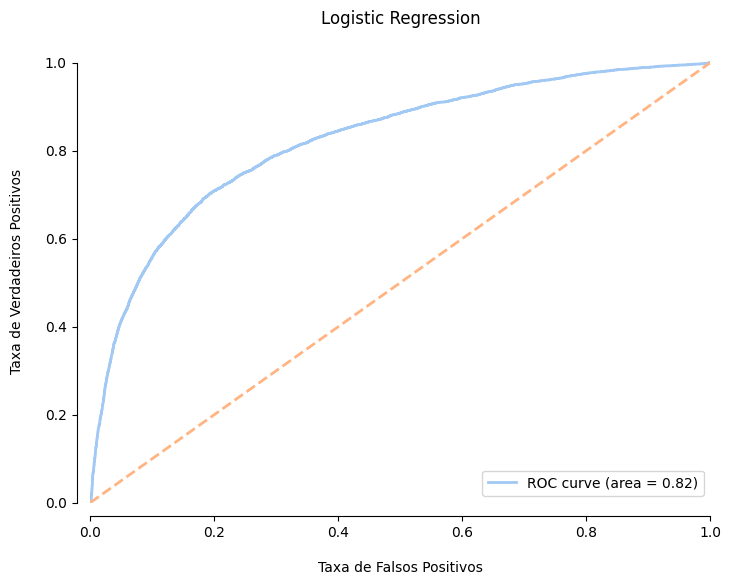

In [8]:
roc_lr = plot_roc_curve(model_lr, X_train, X_test, y_train, y_test, "Logistic Regression")

### Random Forest

In [9]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=STATE)

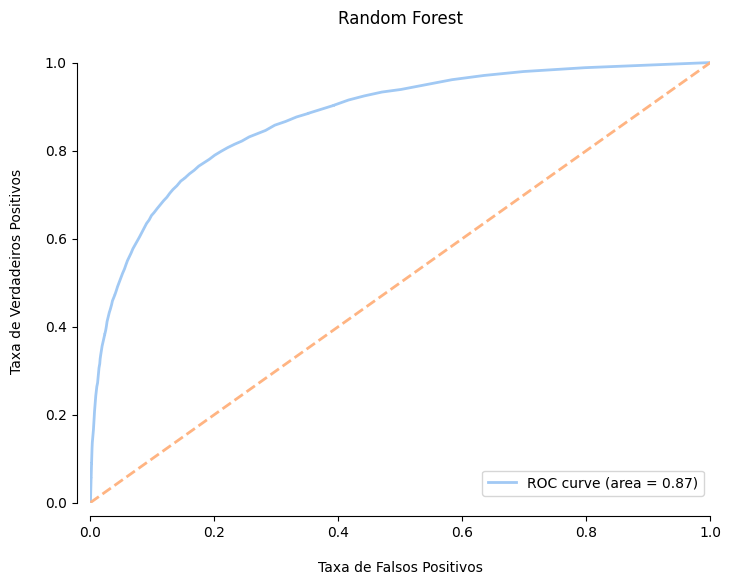

In [10]:
roc_rf = plot_roc_curve(model_rf, X_train, X_test, y_train, y_test, "Random Forest")

### Gradient Boosting

In [11]:
model_gbc = GradientBoostingClassifier(random_state=STATE)

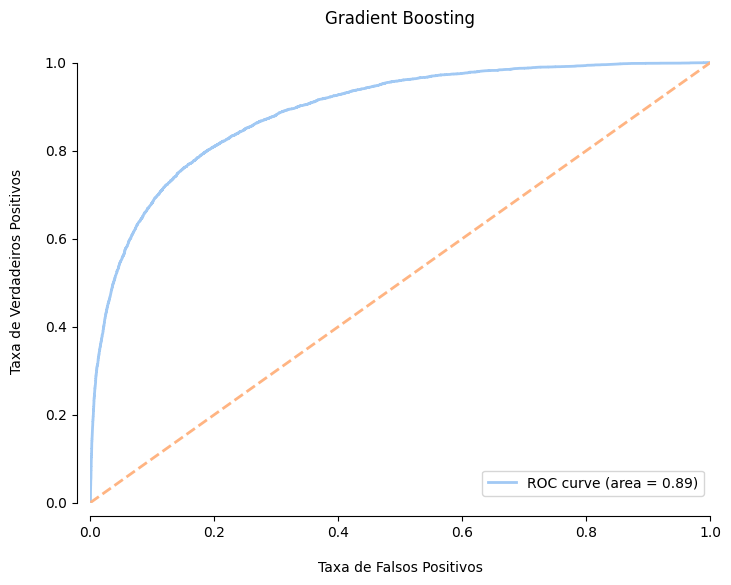

In [12]:
roc_gbc = plot_roc_curve(model_gbc, X_train, X_test, y_train, y_test, "Gradient Boosting")

### MLP Classifier

In [7]:
model_mlp = MLPClassifier(random_state=STATE, max_iter=10000, learning_rate='adaptive')

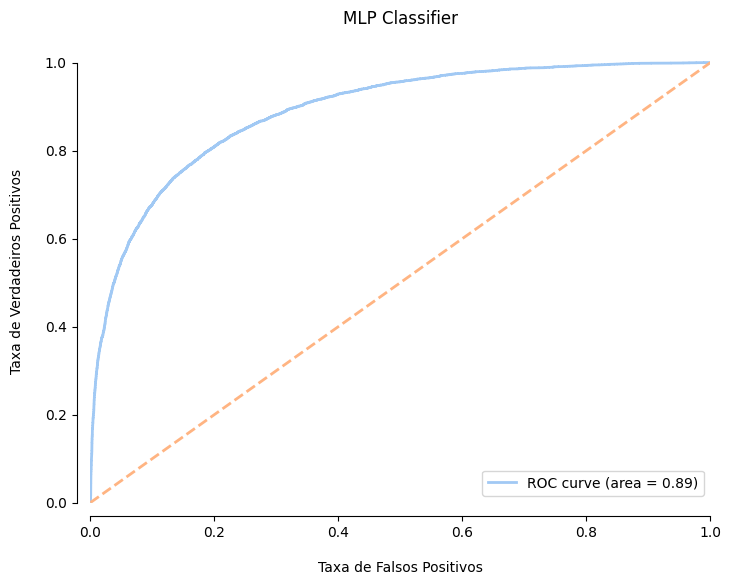

In [8]:
roc_mlp = plot_roc_curve(model_mlp, X_train, X_test, y_train, y_test, "MLP Classifier")

## Modelos com hiperparâmetros

- Função para tunar e plotar ROC curve usando `GridSearchCV `e `Pipeline`

- Configuração do KFold



In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=STATE)

In [10]:
def tune_model(model, param_grid, model_name):
    pipeline = Pipeline([ 
        ('classifier', model)
    ])
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print(f"Melhores parâmetros para {model_name}: {grid_search.best_params_}")
    

    return best_model

### Parâmetros para Regressão logística

In [25]:
lr = 'Regressão logística'

param_grid_lr = {
    'classifier__C': [0.01],
    'classifier__penalty': ['l1'],
    'classifier__solver': ['liblinear']
}
best_model_lr = tune_model(LogisticRegression(max_iter=10000), param_grid_lr, lr)

Melhores parâmetros para Regressão logística: {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}


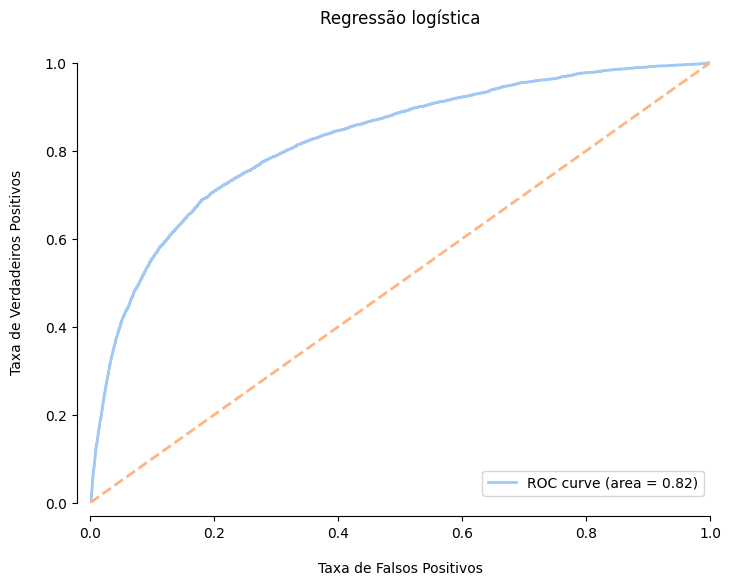

In [27]:
tune_lr = plot_roc_curve(best_model_lr, X_train, X_test, y_train, y_test, lr)

- Infelizmente, não conseguimos nenhuma melhoria no modelo, que permanece com uma precisão de cerca de 82%, mesmo após a otimização.

### Parâmetros para Random Forest

In [30]:
rf = "Random Forest"

param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 4, 5],
    'classifier__min_samples_leaf': [2, 4]
}
best_model_rf = tune_model(RandomForestClassifier(), param_grid_rf, rf)

Melhores parâmetros para Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 200}


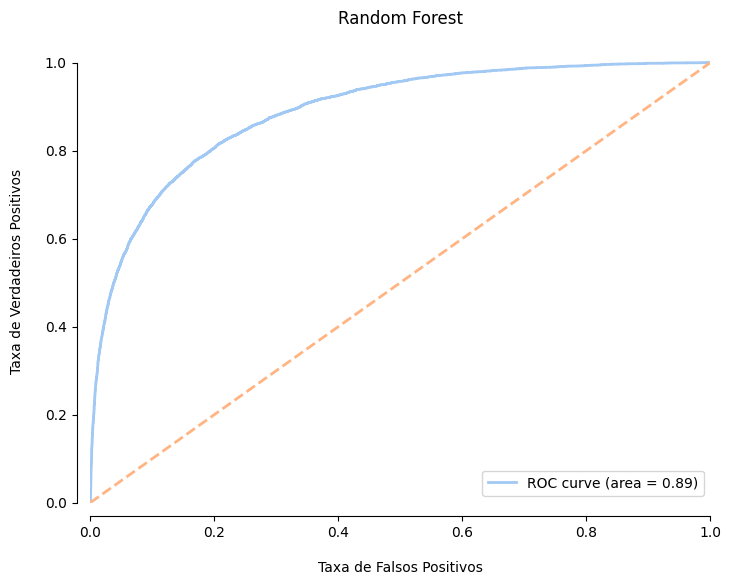

In [31]:
tune_rf = plot_roc_curve(best_model_rf, X_train, X_test, y_train, y_test, rf)

- Novamente, não conseguimos nenhum ganho de perfomace, provavelmente, não conseguiremos superar os 90%

### Parâmetros para MLPClassifier

In [11]:
param_grid_mlp = {
    'classifier__hidden_layer_sizes': [(100,), (100, 50)],
    'classifier__solver': ['sgd', 'adam'],
    'classifier__alpha': [0.001, 0.01],
    'classifier__learning_rate': ['adaptive']
}
best_model_mlp = tune_model(MLPClassifier(max_iter=100), param_grid_mlp, "MLP Classifier")

Melhores parâmetros para MLP Classifier: {'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (100, 50), 'classifier__learning_rate': 'adaptive', 'classifier__solver': 'sgd'}


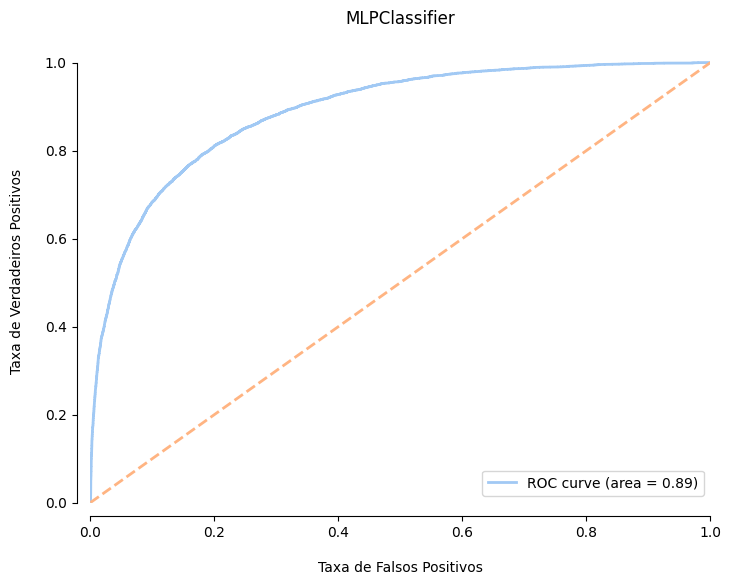

In [13]:
tune_mlp = plot_roc_curve(best_model_mlp, X_train, X_test, y_train, y_test, "MLPClassifier")

- Usaremos os modelos Random Forest e MLPClassifier para validar nossos dados, ambos alcaçaram os 89%

## Dataset de Validação